In [1]:
%pwd

'D:\\ML\\NewYorkTaxi_Jupyter'

In [3]:
import pandas as pd

training = pd.read_csv('data/train.csv', nrows=100)
test = pd.read_csv('data/test.csv', nrows=100)

pd.set_option('display.max_columns',10)
pd.set_option('display.width', 100)

print(training.pickup_datetime.head())
type(training)

0    2009-06-15 17:26:21 UTC
1    2010-01-05 16:52:16 UTC
2    2011-08-18 00:35:00 UTC
3    2012-04-21 04:30:42 UTC
4    2010-03-09 07:51:00 UTC
Name: pickup_datetime, dtype: object


pandas.core.frame.DataFrame

Ideas:
1. Check for empty and null values
1. Simplify pick time to a number between 0 to 24 to just represent time of the day
1. Come up with a new column that shows the distance. This may not be great since the exact locations may affect the length of the trip that could affect the fare.
1. Check for linear correlation

In [4]:
from math import cos, asin, sqrt, pi
import pandas as pd

training = pd.read_csv('data/train.csv', on_bad_lines='skip', nrows=1000000) # TODO remove limit
test = pd.read_csv('data/test.csv')

print("Data loaded.")
print("Read " + str(len(training)) + " training rows")
print("Read " + str(len(test)) + " test rows")

def convert_pickup_times(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC', errors='coerce')

def break_pickup_times_to_components(df):
    df['pickup_year'] = df['pickup_datetime'].dt.year
    df['pickup_month'] = df['pickup_datetime'].dt.month
    #df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    #df['pickup_minute'] = df['pickup_datetime'].dt.minute
    #converting seconds sounds like an overkill so I won't use it
    
    #but day of week sounds like a predictive feature
    df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
    
    #remove the redundant col
    df.drop(columns=['pickup_datetime'], inplace=True)
    
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a)) #2*R*asin...
    
def get_distance(row):
    return distance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])
    
def prepare(df):
    convert_pickup_times(df)
    break_pickup_times_to_components(df)
    df.drop(columns=['key'], inplace=True)
    df['distance'] = df.apply(get_distance, axis=1)
    
prepare(training)
prepare(test)

pd.set_option('display.max_columns',16)
pd.set_option('display.width', 100)
print(training.head())
print(test.head())

Data loaded.
Read 1000000 training rows
Read 9914 test rows
   fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0          4.5        -73.844311        40.721319         -73.841610         40.712278   
1         16.9        -74.016048        40.711303         -73.979268         40.782004   
2          5.7        -73.982738        40.761270         -73.991242         40.750562   
3          7.7        -73.987130        40.733143         -73.991567         40.758092   
4          5.3        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  pickup_year  pickup_month  pickup_hour  pickup_dayofweek  distance  
0                1         2009             6           17                 0  1.030764  
1                1         2010             1           16                 1  8.450134  
2                2         2011             8            0                 3  1.389525  
3                1         2012            

Since the number of cells with null value is relatively small and there's no null values in the test data we can just drop them.

In [9]:
def check_for_nulls(df, dataset):
    is_null = df.isnull()
    row_has_null = is_null.any(axis=1)
    print(dataset + " has " + str(row_has_null.sum()) + " null rows")
    
check_for_nulls(training, "training")
check_for_nulls(test, "test")

training = training[~training.isnull().any(axis=1)]
print(str(len(training)) + " final rows")

training has 0 null rows
test has 0 null rows
999990 final rows


Now, we want to take a look at the correlations between different features and our target variable, i.e. fare amount.

In [11]:
training[training.columns[:]].corr(method='pearson')[:]['fare_amount']

fare_amount          1.000000
pickup_longitude     0.008744
pickup_latitude     -0.007680
dropoff_longitude    0.009644
dropoff_latitude    -0.007629
passenger_count      0.012818
pickup_year          0.115828
pickup_month         0.025104
pickup_hour         -0.018935
pickup_dayofweek     0.002676
distance             0.024779
Name: fare_amount, dtype: float64

array([[<AxesSubplot:title={'center':'fare_amount'}>]], dtype=object)

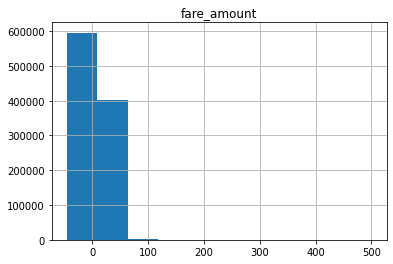

In [17]:
import matplotlib.pyplot as plt

training.hist(column='fare_amount')

In [18]:
from sklearn import svm
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import numpy as np

def custom_cross_validation(cv, x_train, y_train, model):
    pie_len = len(x_train) / cv
    total_len = len(x_train)
    for i in range(0, cv):
        b = int(i * pie_len)
        e = int(b + pie_len)
        train_range = np.r_[0:b, e:total_len]
        test_range = np.r_[b:e]
        model.fit(x_train[train_range], y_train[train_range])
        predictions = model.predict(x_train[test_range])

        rmse = mean_squared_error(y_train[test_range], predictions, squared=False)

        print(rmse)

selectedFeatures = ['distance', 'passenger_count', 'pickup_hour', 'pickup_year']

X = training.loc[:, selectedFeatures].values
y = training.iloc[:, training.columns == 'fare_amount'].values.ravel()

print(X.shape)
print(X)

print("Data was split into features and labels.")

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X) 

# the one col is only added after scaling, these are the constant weights we need for regression
X = np.insert(X, X.shape[1], np.ones(X.shape[0]), axis=1)

print(X[0])

regr = LinearRegression();

custom_cross_validation(5, X, y, regr)

(999990, 4)
[[1.03076393e+00 1.00000000e+00 1.70000000e+01 2.00900000e+03]
 [8.45013360e+00 1.00000000e+00 1.60000000e+01 2.01000000e+03]
 [1.38952523e+00 2.00000000e+00 0.00000000e+00 2.01100000e+03]
 ...
 [1.76174086e+00 5.00000000e+00 1.40000000e+01 2.01300000e+03]
 [1.84268322e+00 1.00000000e+00 0.00000000e+00 2.01100000e+03]
 [7.58051459e-01 1.00000000e+00 1.40000000e+01 2.00900000e+03]]
Data was split into features and labels.
[-0.04983157 -0.51736349  0.53586376 -1.47310915  1.        ]
9.76824903992839
9.97479039743095
9.623479896770487
9.703839468305086
9.68000040753899


In [ ]:
regr.fit(X, y)